In [86]:
import json
from pathlib import Path

import numpy as np
import torch
from kornia.geometry import unproject_points
from structlog import wrap_logger
from torch.functional import F

from courtvision.data import (
    Annotation,
    ClipSegmentResult,
    CourtAnnotatedSample,
    CourtVisionArtifacts,
    KeypointValue,
    PadelDataset,
    RectValue,
    StreamType,
    VideoRectValue,
    dict_to_points,
    download_data_item,
    frames_from_clip_segments,
    get_normalized_calibration_image_points_and_clip_ids,
)
from courtvision.geometry import (
    CameraInfo,
    PadelCourt,
    calibrate_and_evaluate,
    calibrate_camera,
    convert_obj_points_to_planar,
    corners_world_3d,
    denormalize_as_named_points,
    find_optimal_calibration_and_pose,
    get_planar_point_correspondences,
    get_planar_points_padel_court,
    project_points_to_base_plane,
)
from courtvision.models import BallDetector, PlayerDetector
from courtvision.swiss import get_latest_file, mark_as_deprecated
from courtvision.trackers import ParticleFilter
from courtvision.vis import (
    colours_per_player_idx,
    log_ball_detections,
    log_court_layout,
    log_player_detections,
)

In [87]:
ANNOTATION_PATH = Path("../datasets/clip_segmentations")
ANNOTATION_DATA_PATH = Path("../datasets/clip_segmentations/data")
ANNOTATION_DATA_PATH.mkdir(exist_ok=True, parents=True)

court_mesh_path = Path("../blender/basic_image.glb")

annotations_file = get_latest_file(ANNOTATION_PATH, "json")
with open(annotations_file, "r") as f:
    dataset = PadelDataset(samples=json.load(f))

artifacts = CourtVisionArtifacts(
    local_cache_path=ANNOTATION_DATA_PATH / "cache",
    dataset=dataset,
    ball_detector=BallDetector(
        model_file_or_dir=Path(
            "../models/ball_detector/fasterrcnn_resnet50_fpn_project-1-at-2023-05-23-14-38-c467b6ad-67.pt"
        ),
        cache_dir=ANNOTATION_DATA_PATH / "cache",
    ),
    ball_tracker=ParticleFilter(
        num_particles=10,
        court_size=torch.tensor(
            [PadelCourt.width, PadelCourt.length, PadelCourt.backwall_fence_height]
        ),
    ),
    player_detector=PlayerDetector(
        model_dir=Path("../models/player_detection"),
        cache_dir=ANNOTATION_DATA_PATH / "cache",
    ),
    camera_info_path=ANNOTATION_DATA_PATH / "cache" / "camera_info.npz",
    court_layout=PadelCourt(),
)

# Calibrate camera from annotations in the dataset
artifacts = calibrate_camera(artifacts)

2023-06-27 16:48:55 [info     ] Camera already calibrated - using supplied camera_info camera_info=CameraInfo(valid_for_clip_ids={PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output046.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output052.mp4'), PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output048.mp4'), PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output041.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output043.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output049.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output047.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output048.mp4'), PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output052.mp4'), Pos

In [158]:
# Court Floor Pixel Errors
NUM_SAMPLES = 20000
artifacts.ball_tracker.reset(
    num_particles=NUM_SAMPLES,
    court_size=torch.tensor(
        [PadelCourt.width, PadelCourt.length, PadelCourt.backwall_fence_height]
    ),
    world_to_cam=artifacts.camera_info.world_space_to_camera_space(),
    cam_to_image=torch.tensor(artifacts.camera_info.camera_matrix),
)
from itertools import product

grid_on_floor = torch.tensor(
    [
        (float(x), float(y), 0.0)
        for x, y in product(range(int(PadelCourt.width)), range(int(PadelCourt.length)))
    ]
)
grid_on_floor.shape

artifacts.ball_tracker.states[:, 0:3] = grid_on_floor
# artifacts.ball_tracker.states[:, 3] =  0.0

In [159]:
10 / PadelCourt.width

0.1

In [160]:
import rerun as rr

rr.init("courtvision", recording_id="test")
ip, port = (
    "127.0.0.1",
    "9876",
)  # TODO: Make this configurable https://github.com/BenjaminDev/courtvision/issues/4
rr.connect(f"{ip}:{port}")
rr.log_points(
    "world/markers_state",
    positions=artifacts.ball_tracker.xyz,
)

In [161]:
points = artifacts.ball_tracker.state_to_observation(
    state=artifacts.ball_tracker.states,
    world_to_cam=artifacts.ball_tracker.world_to_cam,
    cam_to_image=artifacts.ball_tracker.cam_to_image,
)

In [162]:
points
rr.log_points(
    "world/camera/image/markers",
    positions=points,
    radii=10.1,
)

In [163]:
points

tensor([[ 275.0030,  859.7835],
        [ 278.7727,  853.9895],
        [ 282.5016,  848.2583],
        ...,
        [1278.2543,  302.2532],
        [1277.4346,  300.9128],
        [1276.6193,  299.5793]])

In [164]:
from courtvision.geometry import (
    camera_space_to_world_space,
    compute_ray_intersecting_plane,
)

# Use 2 depth values to unproject the point from the image plane to the camera plane
aves = []
for point in points:
    img_points = point.clone()
    intersection_points = []
    for i in range(100):
        # add noise to point
        delta = torch.tensor([0.01, 0.01]) * 9.75 * i
        p = point + delta
        # print(f"{i=} {delta=} {p=} {point=}")
        img_points = torch.vstack([img_points, p])
        depths = torch.tensor(
            [[1.0 * PadelCourt.court_scale, 20.0 * PadelCourt.court_scale]]
        ).T  # Depth values in [mm * PadelCourt.court_scale]
        mid_feets = p.repeat(depths.shape[0], 1)
        mid_feets_base_camera_space = unproject_points(
            point_2d=mid_feets,
            camera_matrix=artifacts.camera_info.camera_matrix,
            depth=depths,
        ).squeeze(0)
        # Using the Translation and Rotation Vector of the camera, transform the point from camera space to world space
        mid_feet_base_world_space = camera_space_to_world_space(
            mid_feets_base_camera_space.squeeze(0).numpy().T,
            artifacts.camera_info.translation_vector,
            artifacts.camera_info.rotation_vector,
        )
        # Compute the intersection of the ray formed by the camera position and the 3D point with the plane
        intersection = compute_ray_intersecting_plane(
            point_a_on_ray=mid_feet_base_world_space[0].reshape(3, 1),
            point_b_on_ray=mid_feet_base_world_space[1].reshape(3, 1),
        )
        intersection_points.append(intersection)
    rr.log_points(
        "world/camera/image/markers",
        positions=img_points,
        radii=10,
    )
    rr.log_points(
        "world/arkers",
        positions=torch.tensor(intersection_points),
    )

    aves.append(
        (torch.tensor(intersection_points) - torch.tensor(intersection_points)[0])
        .abs()
        .mean()
        .item()
    )

In [133]:
mean = sum(aves) / len(aves)
error = mean / PadelCourt.court_scale

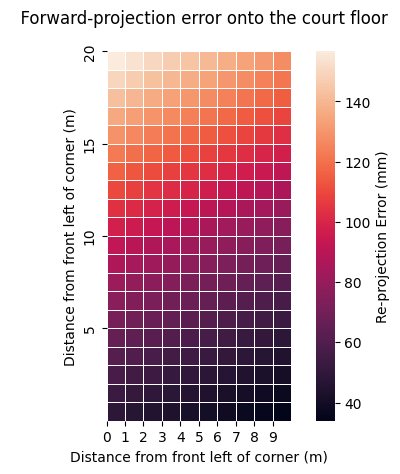

In [214]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import cv2

errors = (np.array(aves) / 10) * 1000
error_map = errors.reshape(int(PadelCourt.width), int(PadelCourt.length)).transpose(
    1, 0
)
error_map = np.flipud(error_map)
error_map = cv2.resize(error_map, (10, 20))
# error_map = np.resize(error_map, (20, 10))

ax = sns.heatmap(
    error_map, linewidth=0.5, cbar_kws={"label": "Re-projection Error (mm)"}
)

plt.title("  Forward-projection error onto the court floor", loc="center", pad=20)
plt.xticks(range(0, 10, 1), range(0, 10, 1), rotation=0)
plt.yticks(range(0, 20, 5), range(20, 0, -5))
plt.xlabel("Distance from front left of corner (m)")
plt.ylabel("Distance from front left of corner (m)")
ax.set_aspect("equal")
plt.show()

In [213]:
import pandas as pd

df = pd.DataFrame(errors)
df.describe()
# errors

,0
count,20000.000000
mean,87.046921
std,31.608976
min,31.767375
25%,59.595178
50%,84.137597
75%,112.780389
max,161.456453


In [178]:
import numpy as np

# Generate a sample NumPy array of size 100x200
original_array = np.random.random((100, 200))

# Upsample the array to size 1000x2000
upsampled_array = np.kron(original_array, np.ones((10, 10)))

# Print the shape of the original and upsampled arrays
print("Original array shape:", original_array.shape)
print("Upsampled array shape:", upsampled_array.shape)

Original array shape: (100, 200)
Upsampled array shape: (1000, 2000)


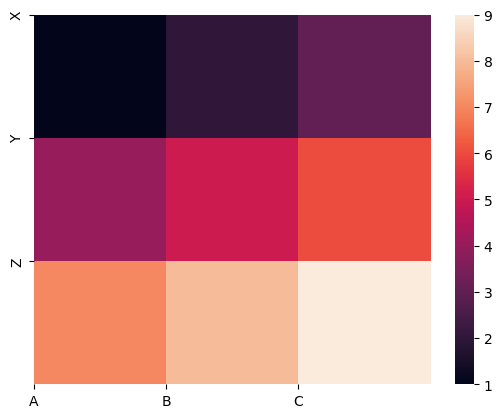

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a sample heatmap data
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# Set custom x and y tick labels
x_labels = ["A", "B", "C"]
y_labels = ["X", "Y", "Z"]

# Create the heatmap
sns.heatmap(data)

# Set the x and y tick labels
plt.xticks(range(len(x_labels)), x_labels)
plt.yticks(range(len(y_labels)), y_labels)

# Show the plot
plt.show()

In [141]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(error_map, linewidth=0.5)
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 import matplotlib.pylab as plt                                                               │
│   4                                                                                              │
│   5 uniform_data = np.random.rand(10, 12)                                                        │
│ ❱ 6 ax = sns.heatmap(error_map, linewidth=0.5)                                                   │
│   7 plt.show()                                                                                   │
│   8                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'error_map' is not defined

In [125]:
uniform_data.shape

(10, 12)

In [132]:
uniform_data[0, 2]

0.7744161580187687